# Suffix vs Non-suffix Words

### Packages

In [29]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from data_processing import DataGenerator
from model import GenderLSTM
from model_evaluation import baseline_accuracy, compare_accuracies
from visualization import plot_metrics

### Hyperparameters

In [30]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 128
hidden_size = 256
batch_size = 64
n_epochs = 20
lr = 0.001

### Datasets

In [31]:
nlexique = pd.read_csv('../data/nlexique.csv')
nlexique = nlexique[['lexeme', 'sg', 'gen']].rename(columns={'sg': 'phon'}).dropna().reset_index(drop=True)
nlexique

,lexeme,phon,gen
0,à-côté,akOte,m
1,à-coup,aku,m
2,à-peu-près,apØpʁɛ,m
3,à-pic,apik,m
4,à-plat,apla,m
...,...,...,...
30999,zurichois,zyʁikwa,m
31000,zydeco,zidəko,f
31001,zygoma,zigOma,m
31002,zygote,zigɔt,m


In [32]:
echantinom = pd.read_csv('../data/Echantinom-full-20210902.csv')
echantinom = echantinom[~echantinom['lemma'].isin(nlexique[nlexique['gen'] == 'b']['lexeme'])][['lemma', 'gen', 'phon', 'suffix']]
echantinom = pd.merge(echantinom, nlexique, left_on='lemma', right_on='lexeme', how='left', suffixes=('_y', ''))\
           .drop(columns=['lexeme', 'phon_y', 'gen_y']).dropna().reset_index(drop=True)

echantinom

,lemma,suffix,phon,gen
0,berlingue,0,bɛʁlɛ̃g,m
1,corton,on,kɔʁtɔ̃,m
2,dabuche,uche,dabyʃ,f
3,faf,0,faf,m
4,gail,0,gaj,f
...,...,...,...,...
4527,palu,0,paly,m
4528,talc,0,talk,m
4529,sauvetage,age,sOvətaʒ,m
4530,plaid,0,plɛd,m


## Orthographic forms

In [33]:
orth_train = nlexique[(~nlexique['lexeme'].isin(echantinom['lemma'])) & (nlexique['gen'] != 'b')][['lexeme', 'gen']]
orth_train

,lexeme,gen
0,à-côté,m
1,à-coup,m
2,à-peu-près,m
3,à-pic,m
4,à-plat,m
...,...,...
30999,zurichois,m
31000,zydeco,f
31001,zygoma,m
31002,zygote,m


In [34]:
orth_test = echantinom[['lemma', 'gen']]
orth_test

,lemma,gen
0,berlingue,m
1,corton,m
2,dabuche,f
3,faf,m
4,gail,f
...,...,...
4527,palu,m
4528,talc,m
4529,sauvetage,m
4530,plaid,m


In [35]:
orth_train_set, orth_valid_set = train_test_split(orth_train, test_size=0.2)

orth_train_generator = DataGenerator(orth_train_set, reverse_nouns=True)
orth_valid_generator = DataGenerator(orth_valid_set, parentgenerator=orth_train_generator, reverse_nouns=True)

orth_model = GenderLSTM(orth_train_generator, embedding_dim, hidden_size, device=DEVICE, reversed=True)
orth_train_metrics, orth_valid_metrics = orth_model.train_model(
    orth_train_generator, orth_valid_generator, n_epochs, batch_size, lr, save_model='../saved_models/nlexique_orth_model.pth'
    )

Epoch: 0
[Train] Loss: 0.3587   Accuracy: 85.42%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 61.46%
[Valid] Loss: 0.2993   Accuracy: 86.87%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 65.76%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.2492   Accuracy: 89.79%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 66.14%
[Valid] Loss: 0.2812   Accuracy: 88.13%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 66.28%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.2246   Accuracy: 90.92%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 66.11%
[Valid] Loss: 0.2456   Accuracy: 90.12%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 67.78%
---------------------------------------------

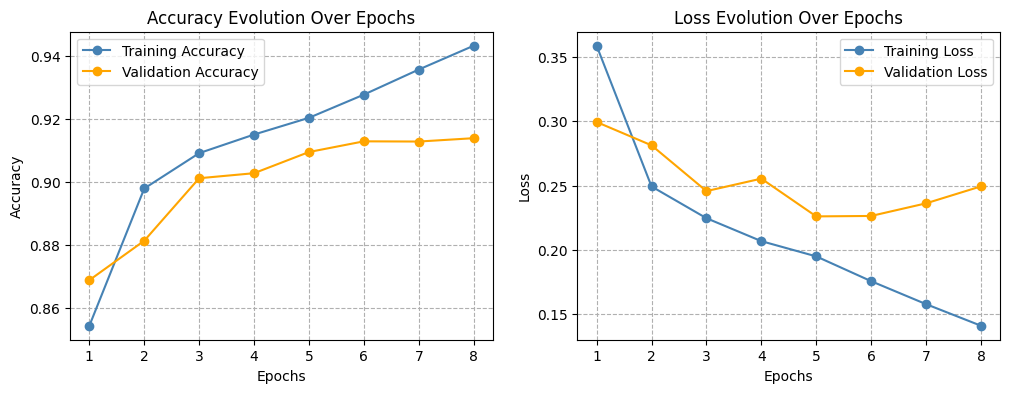

In [36]:
plot_metrics(orth_train_metrics['accuracy'], orth_valid_metrics['accuracy'], orth_train_metrics['loss'], orth_valid_metrics['loss'])

The most frequent label in the dataset is: m


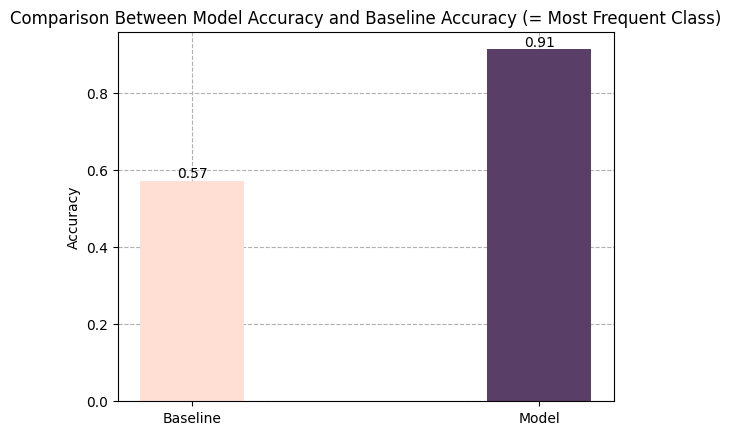

In [37]:
baseline_acc = baseline_accuracy(orth_train_generator, orth_valid_generator, verbose=True)

compare_accuracies(baseline_acc, orth_valid_metrics['accuracy'][-1])

In [38]:
orth_test_generator = DataGenerator(orth_test, parentgenerator=orth_train_generator, reverse_nouns=True)
orth_predictions = orth_model.predict(orth_test_generator, batch_size, set='test')

orth_predictions_df = pd.merge(pd.DataFrame(orth_predictions), echantinom[['lemma', 'phon']], left_on='Form', right_on='lemma', how='left').drop('lemma', axis=1)
orth_predictions_df.insert(1, 'Alt Form', orth_predictions_df.pop('phon'))
orth_predictions_df.to_csv('../results/echantinom_orth_preds.csv', index=False)

## Phonetic forms

In [39]:
phon_train = nlexique[(~nlexique['lexeme'].isin(echantinom['lemma'])) & (nlexique['gen'] != 'b')][['phon', 'gen']]
phon_train

,phon,gen
0,akOte,m
1,aku,m
2,apØpʁɛ,m
3,apik,m
4,apla,m
...,...,...
30999,zyʁikwa,m
31000,zidəko,f
31001,zigOma,m
31002,zigɔt,m


In [40]:
phon_test = echantinom[['phon', 'gen']]
phon_test

,phon,gen
0,bɛʁlɛ̃g,m
1,kɔʁtɔ̃,m
2,dabyʃ,f
3,faf,m
4,gaj,f
...,...,...
4527,paly,m
4528,talk,m
4529,sOvətaʒ,m
4530,plɛd,m


In [41]:
phon_train_set, phon_valid_set = train_test_split(phon_train, test_size=0.2)

phon_train_generator = DataGenerator(phon_train_set, reverse_nouns=True)
phon_valid_generator = DataGenerator(phon_valid_set, parentgenerator=phon_train_generator, reverse_nouns=True)

phon_model = GenderLSTM(phon_train_generator, embedding_dim, hidden_size, device=DEVICE, reversed=True)
phon_train_metrics, phon_valid_metrics = phon_model.train_model(
    phon_train_generator, phon_valid_generator, n_epochs, batch_size, lr, save_model='../saved_models/nlexique_phon_model.pth'
    )

Epoch: 0
[Train] Loss: 0.4348   Accuracy: 78.93%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 55.90%
[Valid] Loss: 0.3991   Accuracy: 80.54%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 55.67%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.3616   Accuracy: 83.08%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 57.03%
[Valid] Loss: 0.3659   Accuracy: 82.83%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 56.72%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.3288   Accuracy: 84.92%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 57.48%
[Valid] Loss: 0.3397   Accuracy: 83.97%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 56.56%
---------------------------------------------

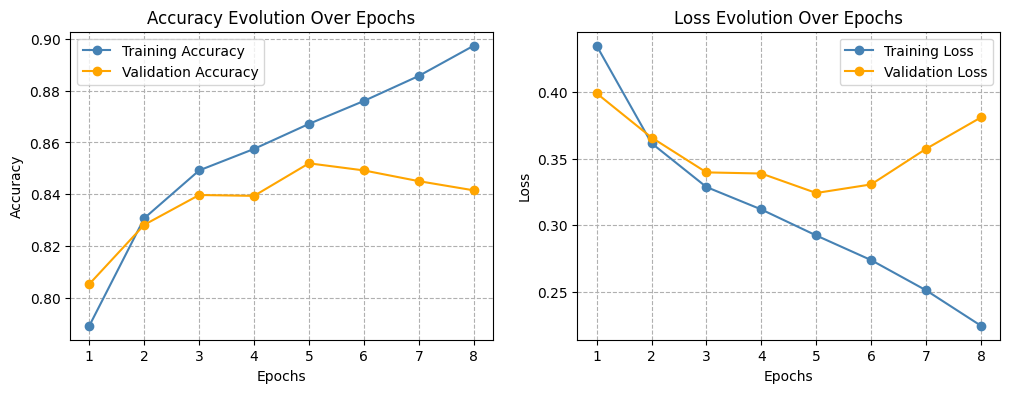

In [42]:
plot_metrics(phon_train_metrics['accuracy'], phon_valid_metrics['accuracy'], phon_train_metrics['loss'], phon_valid_metrics['loss'])

The most frequent label in the dataset is: m


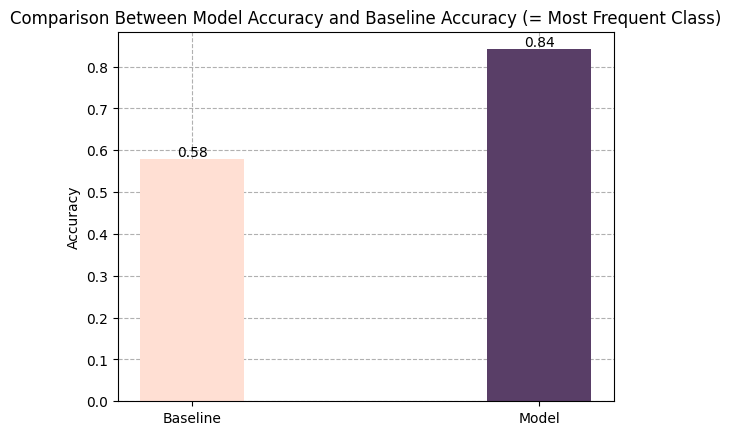

In [43]:
baseline_acc = baseline_accuracy(phon_train_generator, phon_valid_generator, verbose=True)

compare_accuracies(baseline_acc, phon_valid_metrics['accuracy'][-1])

In [44]:
phon_test_generator = DataGenerator(phon_test, parentgenerator=phon_train_generator, reverse_nouns=True)
phon_predictions = phon_model.predict(phon_test_generator, batch_size, set='test')

phon_predictions_df = pd.merge(pd.DataFrame(phon_predictions), echantinom[['lemma', 'phon']], left_on='Form', right_on='phon', how='left').drop('phon', axis=1)
phon_predictions_df.insert(1, 'Alt Form', phon_predictions_df.pop('lemma'))
phon_predictions_df.to_csv('../results/echantinom_phon_preds.csv', index=False)